## Coincidence detection exercieses

In [35]:
try:
    import ipywidgets as widgets
except ImportError:
    widgets = None

try:
    import brian2
except ImportError:
    !pip install brian2

%matplotlib inline
from brian2 import *
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt

# prefs.codegen.target = 'numpy'

In [36]:
rate_max = 400 * Hz
f = 50 * Hz
duration = 1 * second

In [37]:
def generate_input_signal(ipd):
    itd = ipd/(2*pi*f)

    eqs_ears = '''
    theta = 2*pi*f*t + i*ipd : 1
    signal_is_on = int(t<duration-itd)*int(i==0)+int(t>itd)*int(i==1) : 1
    rate = rate_max * 0.5 * (1 + signal_is_on * sin(theta)) : Hz
    '''
    ears = NeuronGroup(2, eqs_ears, threshold='rand() < rate * dt')
    M = SpikeMonitor(ears)
    run(duration)

    return M.i, M.t

In [38]:
N_cd = 100

In [39]:
def localise_from_input(i, t, w, tau):
    ears = SpikeGeneratorGroup(2, i, t) # Create a group of neurons from the spike times
    w = w
    tau = tau*ms

    eqs_cd = '''
    dv/dt = -v/tau : 1
    best_ipd = 2*pi*i/(N_cd-1) : 1
    best_itd = best_ipd/(2*pi*f) : second
    '''

    cd = NeuronGroup(N_cd, eqs_cd, threshold='v > 1', reset='v = 0', method='exact')

    S = Synapses(ears, cd, on_pre='v += w')
    S.connect(p=1)
    S.delay['i==1'] = 'best_itd'

    M = SpikeMonitor(cd)
    run(duration)

    i = max(M.count)
    I = M.count == i
    ipd_est = mean(cd.best_ipd[I]) # Average best_ipd values of most active neurons

    return ipd_est

In [40]:
i, t = generate_input_signal(90)
ipd_est = localise_from_input(i, t, 1, 1)
print(ipd_est)

WARNING    'rate' is an internal variable of group 'neurongroup', but also exists in the run namespace with the value 0.4 * khertz. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


3.6175915404973376


In [50]:
def generate_and_localise(ipd, localiser, *args, **kwargs):
    i, t = generate_input_signal(ipd)
    return localiser(i, t, *args, **kwargs)


In [52]:
generate_and_localise(200, localise_from_input, 0.1, 0.5)

3.1415926535897927

In [57]:
def generate_results(localiser, w, tau):
    ipds = arange(0, 360, 10) * (pi/180)  # IPDs in radians
    ipds_est = array([generate_and_localise(ipd, localiser, w, tau) for ipd in ipds])
    return ipds, ipds_est

In [58]:
def plot_errors(localiser, w, tau):
    ipds, ipds_est = generate_results(localiser, w, tau)

    ipds_est_circ = array([ipds_est, ipds_est+2*pi, ipds_est-2*pi])
    abs_errors_circ = abs(ipds[newaxis, : ] - ipds_est_circ)
    abs_errors_deg = amin(abs_errors_circ, axis=0) * (180/pi)

    figure(figsize=(8, 4), dpi=100)
    subplot(121)
    plot(ipds*180/pi, ipds_est*180/pi, '.k')
    plot([0, 360], [0, 360], '--g')
    xlabel('True IPD (degrees)')
    ylabel('Estimated IPD (degrees)')
    subplot(122)
    plot(ipds*180/pi, abs_errors_deg, '.k')
    mean_abs_error_deg = mean(abs_errors_deg)
    axhline(mean_abs_error_deg, ls='--', c='b', label=f'Mean error = {int(mean_abs_error_deg)}')
    xlabel('True IPD (degrees)')
    ylabel('Absolute error (degrees)')
    legend(loc='best')
    tight_layout()

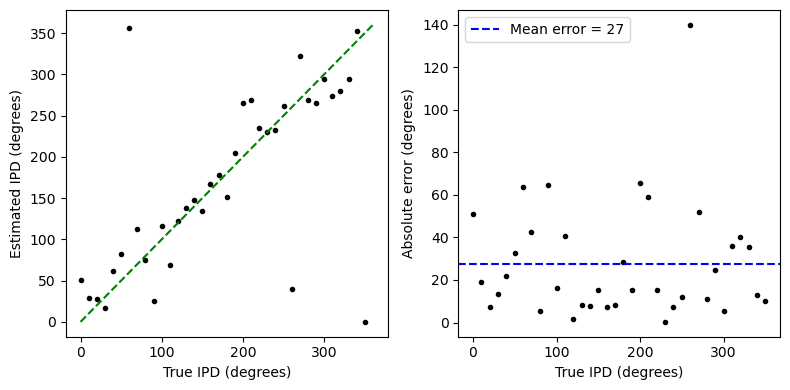

In [60]:
plot_errors(localise_from_input, w=1, tau=1)

interactive(children=(FloatSlider(value=0.5, continuous_update=False, description='w', max=1.0, min=0.1), Floa…

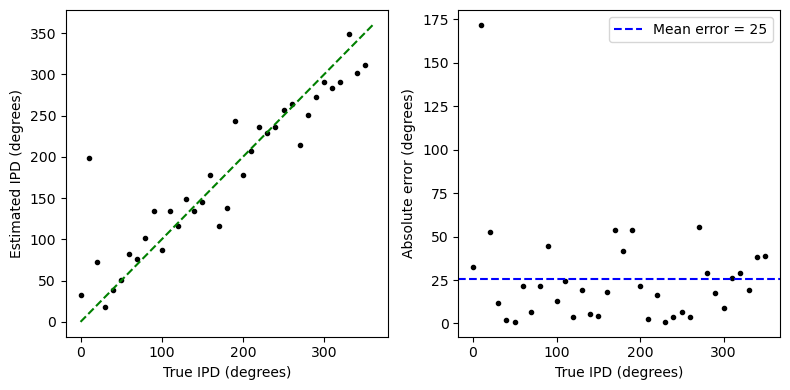

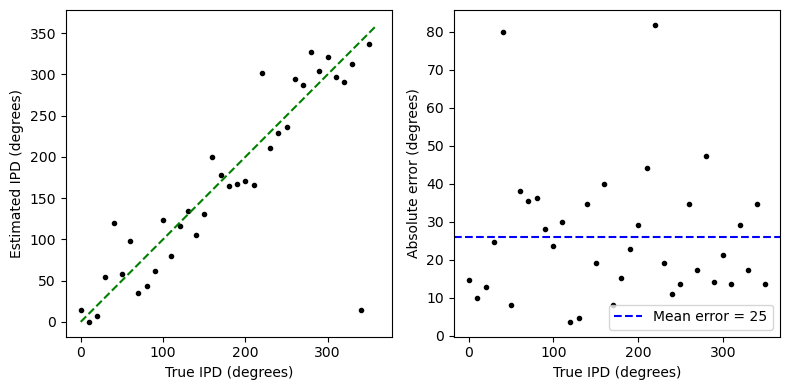

In [63]:
if widgets is not None:
    widgets.interact(plot_errors,
                     localiser= widgets.fixed(localise_from_input),
                     w=widgets.FloatSlider(min=.1, max=1, value=.5, step=.1, continuous_update=False),
                     tau=widgets.FloatSlider(min=.1, max=10, value=1, step=.1, continuous_update=False))
else:
    plot_errors(localise_from_input, w=1, tau=1)